In [22]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import yaml
import open3d as o3d
from tqdm.notebook import tqdm

# Add the project directory to the Python path
sys.path.append('..')

# Import project modules
from src.preprocessing.image_loader import load_image_sequence, resize_images
from src.preprocessing.image_preprocessing import enhance_contrast
from src.feature_extraction.sift_extractor import extract_features_from_image_set
from src.feature_extraction.feature_matcher import match_image_pairs, geometric_verification
from src.sfm.camera_calibration import estimate_camera_matrix
from src.sfm.pose_estimation import estimate_poses_incremental
from src.sfm.triangulation import triangulate_all_points, merge_triangulated_points
from src.sfm.bundle_adjustment import run_global_ba
from src.dense_reconstruction.mvs import process_mvs
from src.dense_reconstruction.point_cloud import process_dense_reconstruction
from src.surface_reconstruction.mesh_generation import process_point_cloud_to_mesh
from src.surface_reconstruction.texture_mapping import create_textured_mesh_from_point_cloud

from src.visualization.plot_matches import plot_matches, plot_feature_matching_analysis
from src.visualization.point_cloud_visualizer import plot_interactive_point_cloud, create_point_cloud_animation
from src.visualization.camera_visualizer import plot_interactive_camera_poses
from src.visualization.mesh_visualizer import visualize_mesh_o3d, plot_interactive_mesh

# Set up matplotlib for inline display
%matplotlib inline
# For newer matplotlib versions (3.6+)
plt.style.use('default')

In [23]:
# Define configuration
config = {
    'preprocessing': {
        'resize_max_dimension': 1000,
        'enhance_contrast': True
    },
    'features': {
        'method': 'sift',  # 'sift', 'surf', or 'orb'
        'max_features': 5000
    },
    'matching': {
        'ratio_threshold': 0.8,
        'geometric_verification': True,
        'min_matches': 12,
        'verification_method': 'fundamental',  # 'fundamental' or 'homography'
        'ransac_threshold': 3.0
    },
    'calibration': {
        'focal_length_factor': 1.2  # Focal length = factor * max(width, height)
    },
    'sfm': {
        'incremental': True,
        'refine_poses': True,
        'min_triangulation_angle_deg': 3.0,
        'reprojection_error_threshold': 4.0
    },
    'mvs': {
        'min_disparity': 0,
        'num_disparities': 64,
        'block_size': 7,
        'filter_depths': True,
        'consistency_threshold': 0.01,
        'num_source_views': 2
    },
    'point_cloud': {
        'voxel_size': 0.01,
        'nb_neighbors': 20,
        'std_ratio': 2.0,
        'confidence_threshold': 0.5
    },
    'surface': {
        'method': 'poisson',  # 'poisson', 'ball_pivoting', or 'alpha_shape'
        'depth': 9,
        'cleanup': True
    },
    'visualization': {
        'point_size': 2,
        'camera_size': 6,
        'point_color_method': 'rgb'  # 'rgb', 'depth', or 'normal'
    }
}

# Create output directory for results
output_dir = "../data/results/"
os.makedirs(output_dir, exist_ok=True)

print("Configuration loaded and output directory created.")

Configuration loaded and output directory created.


Loading images...
Loaded 37 images.
Resized images to maximum dimension of 1000 pixels.
Enhanced image contrast.


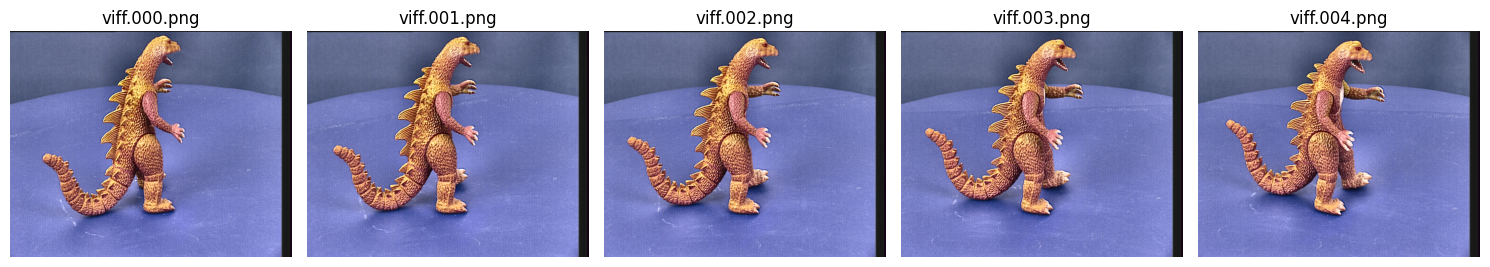

In [24]:
# Define path to dinosaur dataset
dataset_path = '../data/dinosaur/'

# Load images
print("Loading images...")
images = load_image_sequence(dataset_path, pattern="viff.*.png")
print(f"Loaded {len(images)} images.")

# Resize images if needed
max_dim = config['preprocessing']['resize_max_dimension']
images = resize_images(images, max_dimension=max_dim)
print(f"Resized images to maximum dimension of {max_dim} pixels.")

# Enhance contrast if specified
if config['preprocessing']['enhance_contrast']:
    images = enhance_contrast(images)
    print("Enhanced image contrast.")

# Display a subset of the images
n_images = min(5, len(images))
fig, axes = plt.subplots(1, n_images, figsize=(15, 5))

for i in range(n_images):
    img, filename = images[i]
    axes[i].imshow(img)
    axes[i].set_title(filename)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Extracting features from images...
viff.000.png: 1852 keypoints
viff.001.png: 1887 keypoints
viff.002.png: 1820 keypoints
viff.003.png: 1892 keypoints
viff.004.png: 1711 keypoints
viff.005.png: 1641 keypoints
viff.006.png: 1631 keypoints
viff.007.png: 1580 keypoints
viff.008.png: 1482 keypoints
viff.009.png: 1305 keypoints
viff.010.png: 1131 keypoints
viff.011.png: 1088 keypoints
viff.012.png: 1064 keypoints
viff.013.png: 1091 keypoints
viff.014.png: 1108 keypoints
viff.015.png: 1279 keypoints
viff.016.png: 1339 keypoints
viff.017.png: 1535 keypoints
viff.018.png: 1642 keypoints
viff.019.png: 1771 keypoints
viff.020.png: 1890 keypoints
viff.021.png: 1923 keypoints
viff.022.png: 1971 keypoints
viff.023.png: 2007 keypoints
viff.024.png: 2100 keypoints
viff.025.png: 2032 keypoints
viff.026.png: 1893 keypoints
viff.027.png: 1882 keypoints
viff.028.png: 1720 keypoints
viff.029.png: 1560 keypoints
viff.030.png: 1559 keypoints
viff.031.png: 1518 keypoints
viff.032.png: 1694 keypoints
viff.03

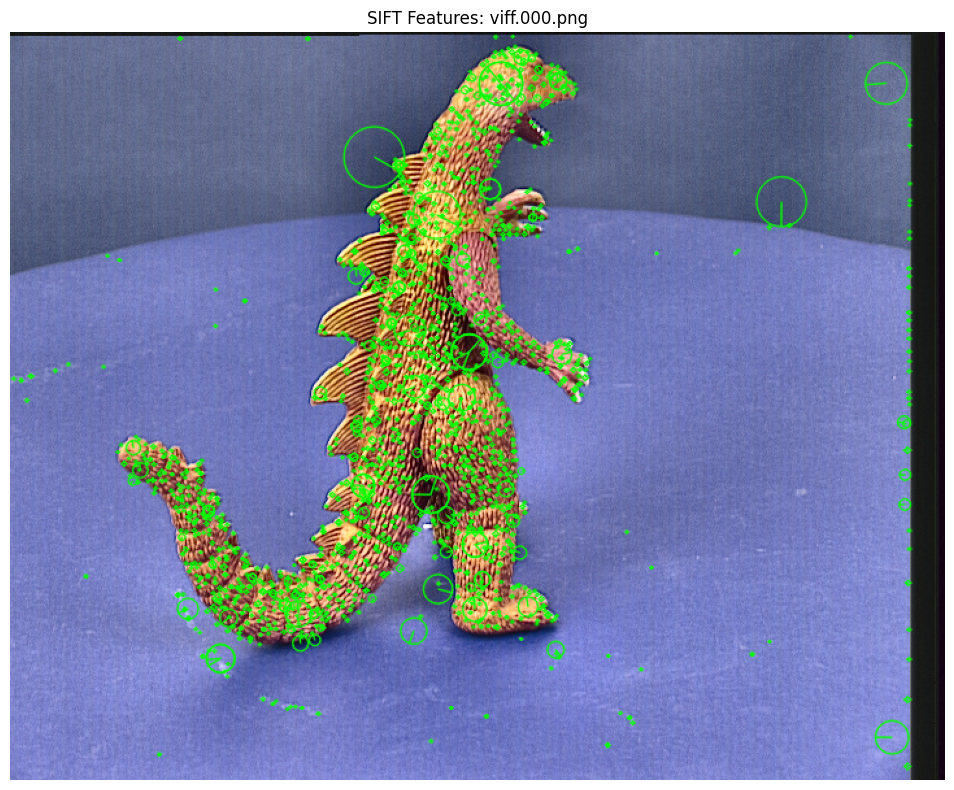


Matching features between image pairs...
Created 467 image pairs for matching
Successfully matched 417 image pairs.


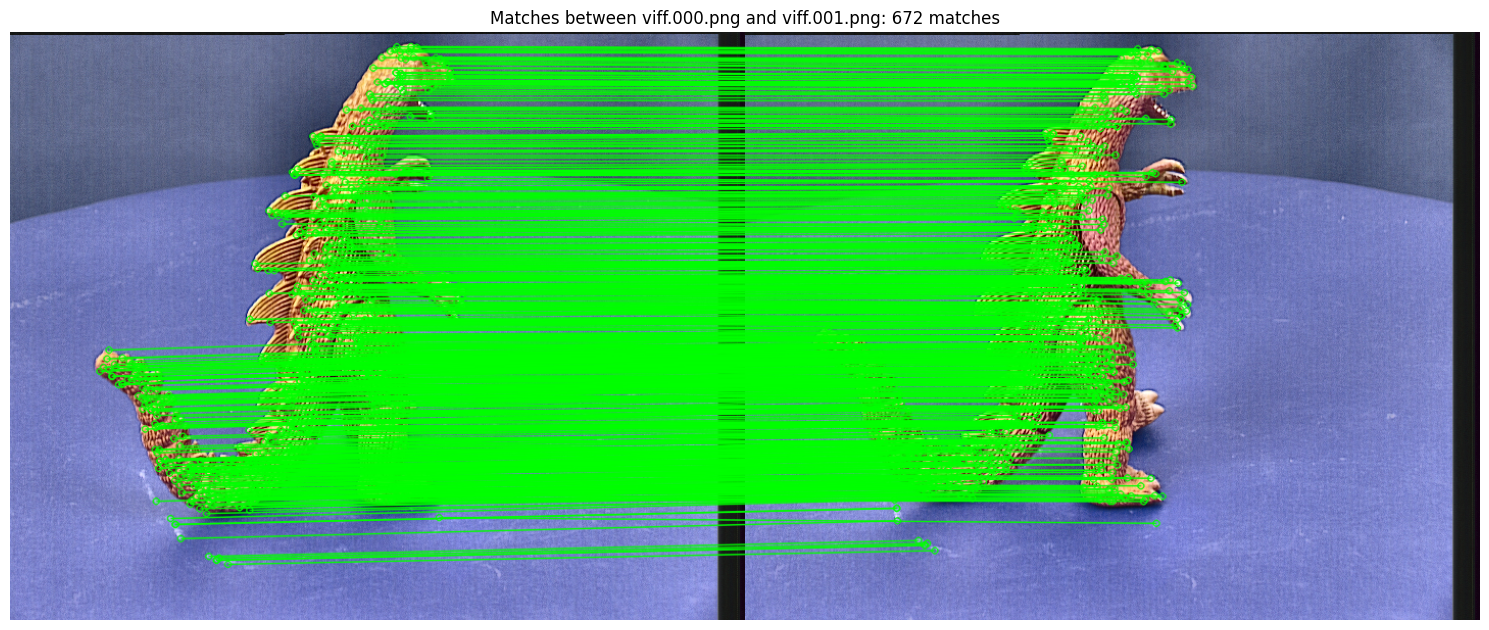

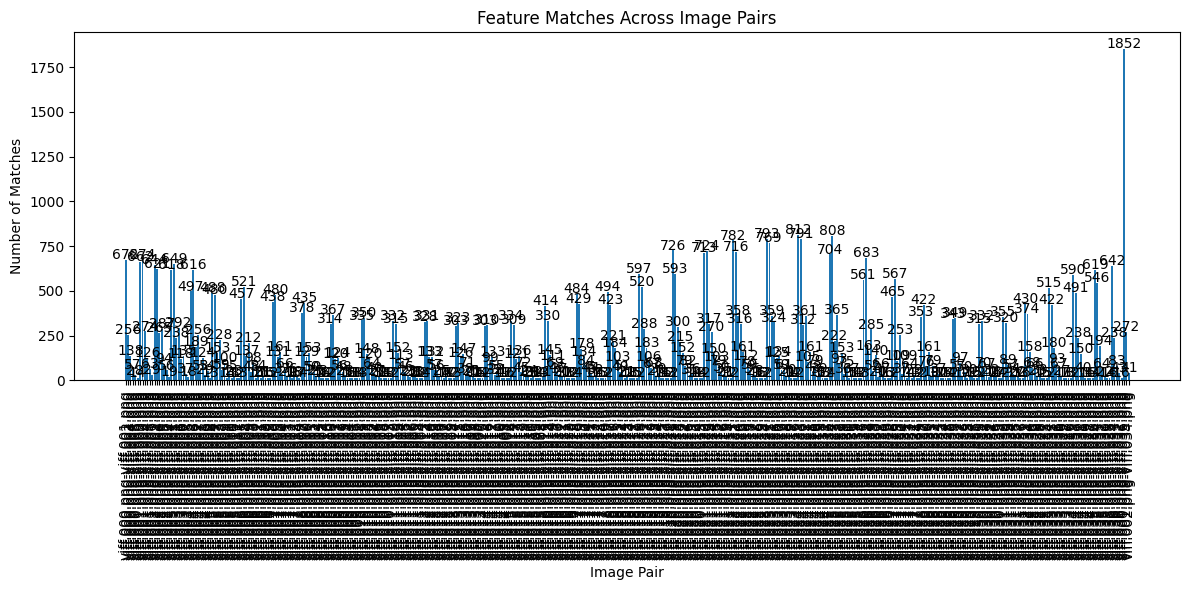

In [25]:
# Extract features
print("\nExtracting features from images...")
feature_method = config['features']['method']
max_features = config['features']['max_features']

features_dict = extract_features_from_image_set(images, method=feature_method, n_features=max_features)

# Print feature counts
for filename, (keypoints, descriptors) in features_dict.items():
    print(f"{filename}: {len(keypoints)} keypoints")

# Visualize keypoints on a sample image
sample_img, sample_filename = images[0]
sample_keypoints, _ = features_dict[sample_filename]

# Plot keypoints
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(cv2.drawKeypoints(sample_img, sample_keypoints, None, 
                          color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
ax.set_title(f"{feature_method.upper()} Features: {sample_filename}")
ax.axis('off')
plt.tight_layout()
plt.show()

# Match features between consecutive image pairs plus loop closure
print("\nMatching features between image pairs...")
filenames = [filename for _, filename in images]

# Replace the current image_pairs creation with this:
image_pairs = []
for i in range(len(filenames)):
    # Match each image with several others in both directions
    for j in range(1, 8):  # Try matching with next/previous 7 images
        # Forward matching
        if i + j < len(filenames):
            image_pairs.append((filenames[i], filenames[i+j]))
        # Backward matching
        if i - j >= 0:
            image_pairs.append((filenames[i], filenames[i-j]))

# Add some loop closures for additional robustness
for i in range(5):
    if i < len(filenames) and len(filenames)-i-1 >= 0:
        image_pairs.append((filenames[i], filenames[-i-1]))

print(f"Created {len(image_pairs)} image pairs for matching")

# Match features
matches_dict = match_image_pairs(
    features_dict, 
    image_pairs, 
    config['matching']['ratio_threshold'],
    config['matching']['geometric_verification'],
    config['matching']['min_matches']
)

print(f"Successfully matched {len(matches_dict)} image pairs.")

# Display matches for a sample pair
if len(matches_dict) > 0:
    # Choose a sample pair
    sample_pair = list(matches_dict.keys())[0]
    img1_name, img2_name = sample_pair
    kp1, kp2, matches = matches_dict[sample_pair]
    
    # Get the images
    img1 = next(img for img, filename in images if filename == img1_name)
    img2 = next(img for img, filename in images if filename == img2_name)
    
    # Plot matches
    plot_matches(img1, kp1, img2, kp2, matches[:1000],  # Only plot first 100 matches for clarity
                title=f"Matches between {img1_name} and {img2_name}: {len(matches)} matches")

    # Show matching statistics across all pairs
    plot_feature_matching_analysis(matches_dict, figsize=(12, 6))

In [26]:
# Estimate camera intrinsics
print("\nEstimating camera intrinsics...")
sample_img, _ = images[0]
image_shape = sample_img.shape
focal_length_factor = config['calibration']['focal_length_factor']
focal_length = focal_length_factor * max(image_shape[0], image_shape[1])
K = estimate_camera_matrix(image_shape, focal_length)

print("Estimated camera matrix:")
print(K)

# Estimate camera poses using incremental SfM
print("\nEstimating camera poses using Structure from Motion...")
camera_poses = estimate_poses_incremental(matches_dict, K, config['matching']['min_matches'])

print(f"Estimated poses for {len(camera_poses)} cameras.")

# Visualize camera poses
if len(camera_poses) > 0:
    # Extract camera positions for visualization (camera center is -R^T * t)
    camera_positions = {name: -R.T @ t for name, (R, t) in camera_poses.items()}
    
    # Plot camera positions
    plot_interactive_camera_poses(camera_poses)


Estimating camera intrinsics...
Estimated camera matrix:
[[864.   0. 360.]
 [  0. 864. 288.]
 [  0.   0.   1.]]

Estimating camera poses using Structure from Motion...
PnP successful with 625 inliers. Mean reprojection error: 3.61 pixels
Added pose for viff.001.png using 625 / 672 points
Maximum attempts reached for viff.002.png. Permanently skipping.
Maximum attempts reached for viff.003.png. Permanently skipping.
PnP successful with 552 inliers. Mean reprojection error: 2.65 pixels
Added pose for viff.035.png using 552 / 642 points


KeyError: 'viff.002.png'

In [ ]:
# Triangulate 3D points
print("\nTriangulating 3D points...")
points_3d, point_observations = triangulate_all_points(camera_poses, matches_dict, K)

print(f"Triangulated {len(points_3d)} 3D points.")

# Merge close points
merged_points, merged_observations = merge_triangulated_points(points_3d, point_observations)
print(f"After merging: {len(merged_points)} 3D points.")

# Bundle adjustment to refine camera poses and 3D points
if config['sfm']['refine_poses'] and len(merged_points) > 0:
    print("\nRunning bundle adjustment...")
    refined_poses, refined_points, _ = run_global_ba(camera_poses, matches_dict, K)
    camera_poses = refined_poses
    points_3d = refined_points
    print("Bundle adjustment complete.")

# Visualize sparse point cloud
if len(points_3d) > 0:
    print("\nVisualizing sparse point cloud...")
    points_array = np.array(points_3d)
    
    # Assign random colors for visualization
    np.random.seed(42)  # For reproducibility
    colors = np.random.rand(len(points_array), 3)
    
    # Interactive visualization
    plot_interactive_point_cloud(points_array, colors, title="Sparse 3D Reconstruction")

    # Save sparse point cloud
    sparse_cloud_file = os.path.join(output_dir, "dinosaur_sparse.ply")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_array)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.io.write_point_cloud(sparse_cloud_file, pcd)
    print(f"Saved sparse point cloud to {sparse_cloud_file}")

In [ ]:
# Run Multi-View Stereo to get dense point cloud
print("\nRunning Multi-View Stereo for dense reconstruction...")
mvs_results = process_mvs(images, camera_poses, K, config['mvs'])

# Extract depth maps
depth_maps = mvs_results['filtered_depth_maps']
confidence_maps = mvs_results['confidence_maps']

print(f"Generated {len(depth_maps)} depth maps.")

# Visualize a sample depth map
if len(depth_maps) > 0:
    # Choose a sample depth map
    sample_name = list(depth_maps.keys())[0]
    depth_map = depth_maps[sample_name]
    
    # Normalize depth for visualization
    valid_mask = depth_map > 0
    if np.any(valid_mask):
        min_depth = np.min(depth_map[valid_mask])
        max_depth = np.max(depth_map[valid_mask])
        normalized_depth = np.zeros_like(depth_map)
        normalized_depth[valid_mask] = (depth_map[valid_mask] - min_depth) / (max_depth - min_depth)
        
        # Display depth map
        plt.figure(figsize=(10, 8))
        plt.imshow(normalized_depth, cmap='jet')
        plt.colorbar(label='Normalized Depth')
        plt.title(f"Depth Map: {sample_name}")
        plt.axis('off')
        plt.show()

# Generate dense point cloud
print("\nGenerating dense point cloud from depth maps...")
dense_results = process_dense_reconstruction(
    images, camera_poses, K, depth_maps, confidence_maps, config['point_cloud'])

# Extract results
dense_points = dense_results['filtered_points']
dense_colors = dense_results['filtered_colors']

if len(dense_points) > 0:
    print(f"Dense point cloud contains {len(dense_points)} points.")
    
    # Visualize dense point cloud
    plot_interactive_point_cloud(dense_points, dense_colors, title="Dense 3D Reconstruction")
    
    # Save dense point cloud
    dense_cloud_file = os.path.join(output_dir, "dinosaur_dense.ply")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(dense_points)
    pcd.colors = o3d.utility.Vector3dVector(dense_colors)
    o3d.io.write_point_cloud(dense_cloud_file, pcd)
    print(f"Saved dense point cloud to {dense_cloud_file}")

In [ ]:
# Generate mesh from dense point cloud
print("\nGenerating surface mesh...")
mesh, pcd = process_point_cloud_to_mesh(
    dense_points, dense_colors, method=config['surface']['method'])

# Display mesh statistics
print(f"Mesh contains {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles.")

# Visualize mesh (this will open an Open3D window)
print("\nVisualizing mesh (this will open a new window)...")
visualize_mesh_o3d(mesh, window_name="Reconstructed Mesh")

# Save mesh
mesh_file = os.path.join(output_dir, "dinosaur_mesh.ply")
o3d.io.write_triangle_mesh(mesh_file, mesh)
print(f"Saved mesh to {mesh_file}")

In [ ]:
# Generate textured mesh
print("\nGenerating textured mesh...")
textured_mesh = create_textured_mesh_from_point_cloud(
    dense_points, dense_colors, images, camera_poses, K, 
    reconstruction_method=config['surface']['method'])

# Visualize textured mesh (this will open an Open3D window)
print("\nVisualizing textured mesh (this will open a new window)...")
visualize_mesh_o3d(textured_mesh, window_name="Textured Mesh")

# Save textured mesh
textured_mesh_file = os.path.join(output_dir, "dinosaur_textured.obj")
o3d.io.write_triangle_mesh(textured_mesh_file, textured_mesh)
print(f"Saved textured mesh to {textured_mesh_file}")

In [ ]:
# Create interactive mesh visualization using Plotly
print("\nCreating interactive mesh visualization...")

# Extract mesh data for Plotly
vertices = np.asarray(mesh.vertices)
triangles = np.asarray(mesh.triangles)
vertex_colors = np.asarray(mesh.vertex_colors) if mesh.has_vertex_colors() else None

# Create interactive plot
plot_interactive_mesh(vertices, triangles, vertex_colors, title="Interactive 3D Dinosaur Model")

# Create rotating animation (optional)
print("\nCreating 360° animation of the model...")
animation = create_point_cloud_animation(
    dense_points, dense_colors, n_frames=36, 
    output_file=os.path.join(output_dir, "dinosaur_animation.html"))

print("\n3D reconstruction pipeline complete!")
print(f"All results saved to: {output_dir}")

# Display summary of the reconstruction
print("\nReconstruction Summary:")
print(f"Images processed: {len(images)}")
print(f"Camera poses estimated: {len(camera_poses)}")
print(f"Sparse points: {len(points_3d)}")
print(f"Dense points: {len(dense_points)}")
print(f"Mesh vertices: {len(mesh.vertices)}")
print(f"Mesh triangles: {len(mesh.triangles)}")

In [ ]:
# Simplify and optimize mesh for 3D printing (optional)
print("\nOptimizing mesh for export...")

# Make a copy of the mesh for optimization
export_mesh = o3d.geometry.TriangleMesh(mesh)

# Remove any non-manifold edges
export_mesh.remove_non_manifold_edges()

# Fill holes
export_mesh = export_mesh.filter_smooth_simple(5)  # Smooth mesh

# Simplify mesh to reduce polygon count
target_triangles = int(len(export_mesh.triangles) * 0.5)  # Reduce to 50%
export_mesh = export_mesh.simplify_quadric_decimation(target_triangles)

# Fix mesh normals
export_mesh.compute_vertex_normals()

# Save optimized mesh in multiple formats
o3d.io.write_triangle_mesh(os.path.join(output_dir, "dinosaur_optimized.obj"), export_mesh)
o3d.io.write_triangle_mesh(os.path.join(output_dir, "dinosaur_optimized.stl"), export_mesh)

print("Optimized mesh exported in OBJ and STL formats, suitable for 3D printing and other applications.")